In [1]:
#importing necessary packages
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, precision_recall_curve, auc
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
import warnings
warnings.filterwarnings("ignore")

In [2]:
from google.colab import drive
drive.mount('/content/drive' , force_remount = True)

Mounted at /content/drive


In [3]:
#Loading Dataset which we have processed earlier
X_train = pd.read_csv('/content/drive/MyDrive/Credit_risk_model-main/Pre-processed files/train_data.csv' , index_col=None)
Y_train = pd.read_csv('/content/drive/MyDrive/Credit_risk_model-main/Pre-processed files/train_label.csv' , index_col=None)
X_test = pd.read_csv('/content/drive/MyDrive/Credit_risk_model-main/Pre-processed files/test_data.csv' , index_col=None)
Y_test= pd.read_csv('/content/drive/MyDrive/Credit_risk_model-main/Pre-processed files/test_label.csv' , index_col=None)

In [4]:
#Checking shape of data
print("Shape of X_train",X_train.shape)
print("Shape of Y_train",Y_train.shape)
print("Shape of X_test",X_test.shape)
print("Shape of Y_test",Y_test.shape)

Shape of X_train (326399, 36)
Shape of Y_train (326399, 1)
Shape of X_test (139886, 36)
Shape of Y_test (139886, 1)


$\text{Re-applying same steps as done in feature engineering using WoE and IV}$

In [5]:
#list of all the categories having one category from each of the global features that can be dropped from analysis as seen above(low or too high WoE/IV value)
categories = ['months_since_last_credit_pull_d:>75', 'months_since_issue_d:>122', 'months_since_earliest_cr_line:>434', 'total_rev_hi_lim:>79,780', 'total_rec_int:>7,260', 'total_pymnt:>25,000', 'out_prncp:>15,437', 'revol_util:>1.0', 'inq_last_6mths:>4', 'dti:>35.191','annual_inc:>150K', 'int_rate:>20.281', 'term:60', 'verification_status:Not Verified', 'home_ownership:MORTGAGE', 'grade:G']

In [6]:
class WoE_Binning(BaseEstimator, TransformerMixin):
    def __init__(self, X): # no *args or *kargs
        self.X = X
    def fit(self, X, y = None):
        return self #nothing else to do
    def transform(self, X):
        X_new = X.loc[:, 'grade:A': 'grade:G']
        X_new['home_ownership:OWN'] = X.loc[:,'home_ownership:OWN']
        X_new['home_ownership:MORTGAGE'] = X.loc[:,'home_ownership:MORTGAGE']
        X_new['home_ownership:OTHER_NONE_RENT'] = sum([X['home_ownership:OTHER'], X['home_ownership:NONE'], X['home_ownership:RENT']])
        X_new = pd.concat([X_new, X.loc[:, 'verification_status:Not Verified':'verification_status:Verified']], axis = 1)
        X_new['term:36'] = np.where((X['term'] == 36), 1, 0)
        X_new['term:60'] = np.where((X['term'] == 60), 1, 0)
        X_new['int_rate:<7.071'] = np.where((X['int_rate'] <= 7.071), 1, 0)
        X_new['int_rate:7.071-10.374'] = np.where((X['int_rate'] > 7.071) & (X['int_rate'] <= 10.374), 1, 0)
        X_new['int_rate:10.374-13.676'] = np.where((X['int_rate'] > 10.374) & (X['int_rate'] <= 13.676), 1, 0)
        X_new['int_rate:13.676-15.74'] = np.where((X['int_rate'] > 13.676) & (X['int_rate'] <= 15.74), 1, 0)
        X_new['int_rate:15.74-20.281'] = np.where((X['int_rate'] > 15.74) & (X['int_rate'] <= 20.281), 1, 0)
        X_new['int_rate:>20.281'] = np.where((X['int_rate'] > 20.281), 1, 0)
        X_new['annual_inc:missing'] = np.where(X['annual_inc'].isnull(), 1, 0)
        X_new['annual_inc:<28,555'] = np.where((X['annual_inc'] <= 28555), 1, 0)
        X_new['annual_inc:28,555-37,440'] = np.where((X['annual_inc'] > 28555) & (X['annual_inc'] <= 37440), 1, 0)
        X_new['annual_inc:37,440-61,137'] = np.where((X['annual_inc'] > 37440) & (X['annual_inc'] <= 61137), 1, 0)
        X_new['annual_inc:61,137-81,872'] = np.where((X['annual_inc'] > 61137) & (X['annual_inc'] <= 81872), 1, 0)
        X_new['annual_inc:81,872-102,606'] = np.where((X['annual_inc'] > 81872) & (X['annual_inc'] <= 102606), 1, 0)
        X_new['annual_inc:102,606-120,379'] = np.where((X['annual_inc'] > 102606) & (X['annual_inc'] <= 120379), 1, 0)
        X_new['annual_inc:120,379-150,000'] = np.where((X['annual_inc'] > 120379) & (X['annual_inc'] <= 150000), 1, 0)
        X_new['annual_inc:>150K'] = np.where((X['annual_inc'] > 150000), 1, 0)
        X_new['dti:<=1.6'] = np.where((X['dti'] <= 1.6), 1, 0)
        X_new['dti:1.6-5.599'] = np.where((X['dti'] > 1.6) & (X['dti'] <= 5.599), 1, 0)
        X_new['dti:5.599-10.397'] = np.where((X['dti'] > 5.599) & (X['dti'] <= 10.397), 1, 0)
        X_new['dti:10.397-15.196'] = np.where((X['dti'] > 10.397) & (X['dti'] <= 15.196), 1, 0)
        X_new['dti:15.196-19.195'] = np.where((X['dti'] > 15.196) & (X['dti'] <= 19.195), 1, 0)
        X_new['dti:19.195-24.794'] = np.where((X['dti'] > 19.195) & (X['dti'] <= 24.794), 1, 0)
        X_new['dti:24.794-35.191'] = np.where((X['dti'] > 24.794) & (X['dti'] <= 35.191), 1, 0)
        X_new['dti:>35.191'] = np.where((X['dti'] > 35.191), 1, 0)
        X_new['inq_last_6mths:missing'] = np.where(X['inq_last_6mths'].isnull(), 1, 0)
        X_new['inq_last_6mths:0'] = np.where((X['inq_last_6mths'] == 0), 1, 0)
        X_new['inq_last_6mths:1-2'] = np.where((X['inq_last_6mths'] >= 1) & (X['inq_last_6mths'] <= 2), 1, 0)
        X_new['inq_last_6mths:3-4'] = np.where((X['inq_last_6mths'] >= 3) & (X['inq_last_6mths'] <= 4), 1, 0)
        X_new['inq_last_6mths:>4'] = np.where((X['inq_last_6mths'] > 4), 1, 0)
        # We will discretize on the deciles for revol_util
        X_new['revol_util:missing'] = np.where(X['revol_util'].isnull(), 1, 0)
        X_new['revol_util:<0.1'] = np.where((X['revol_util'] <= 0.1), 1, 0)
        X_new['revol_util:0.1-0.2'] = np.where((X['revol_util'] > 0.1) & (X['revol_util'] <= 0.2), 1, 0)
        X_new['revol_util:0.2-0.3'] = np.where((X['revol_util'] > 0.2) & (X['revol_util'] <= 0.3), 1, 0)
        X_new['revol_util:0.3-0.4'] = np.where((X['revol_util'] > 0.3) & (X['revol_util'] <= 0.4), 1, 0)
        X_new['revol_util:0.4-0.5'] = np.where((X['revol_util'] > 0.4) & (X['revol_util'] <= 0.5), 1, 0)
        X_new['revol_util:0.5-0.6'] = np.where((X['revol_util'] > 0.5) & (X['revol_util'] <= 0.6), 1, 0)
        X_new['revol_util:0.6-0.7'] = np.where((X['revol_util'] > 0.6) & (X['revol_util'] <= 0.7), 1, 0)
        X_new['revol_util:0.7-0.8'] = np.where((X['revol_util'] > 0.7) & (X['revol_util'] <= 0.8), 1, 0)
        X_new['revol_util:0.8-0.9'] = np.where((X['revol_util'] > 0.8) & (X['revol_util'] <= 0.9), 1, 0)
        X_new['revol_util:0.9-1.0'] = np.where((X['revol_util'] > 0.9) & (X['revol_util'] <= 1.0), 1, 0)
        X_new['revol_util:>1.0'] = np.where((X['revol_util'] > 1.0), 1, 0)
        X_new['out_prncp:<1,286'] = np.where((X['out_prncp'] <= 1286), 1, 0)
        X_new['out_prncp:1,286-6,432'] = np.where((X['out_prncp'] > 1286) & (X['out_prncp'] <= 6432), 1, 0)
        X_new['out_prncp:6,432-9,005'] = np.where((X['out_prncp'] > 6432) & (X['out_prncp'] <= 9005), 1, 0)
        X_new['out_prncp:9,005-10,291'] = np.where((X['out_prncp'] > 9005) & (X['out_prncp'] <= 10291), 1, 0)
        X_new['out_prncp:10,291-15,437'] = np.where((X['out_prncp'] > 10291) & (X['out_prncp'] <= 15437), 1, 0)
        X_new['out_prncp:>15,437'] = np.where((X['out_prncp'] > 15437), 1, 0)
        X_new['total_pymnt:<10,000'] = np.where((X['total_pymnt'] <= 10000), 1, 0)
        X_new['total_pymnt:10,000-15,000'] = np.where((X['total_pymnt'] > 10000) & (X['total_pymnt'] <= 15000), 1, 0)
        X_new['total_pymnt:15,000-20,000'] = np.where((X['total_pymnt'] > 15000) & (X['total_pymnt'] <= 20000), 1, 0)
        X_new['total_pymnt:20,000-25,000'] = np.where((X['total_pymnt'] > 20000) & (X['total_pymnt'] <= 25000), 1, 0)
        X_new['total_pymnt:>25,000'] = np.where((X['total_pymnt'] > 25000), 1, 0)
        X_new['total_rec_int:<1,089'] = np.where((X['total_rec_int'] <= 1089), 1, 0)
        X_new['total_rec_int:1,089-2,541'] = np.where((X['total_rec_int'] > 1089) & (X['total_rec_int'] <= 2541), 1, 0)
        X_new['total_rec_int:2,541-4,719'] = np.where((X['total_rec_int'] > 2541) & (X['total_rec_int'] <= 4719), 1, 0)
        X_new['total_rec_int:4,719-7,260'] = np.where((X['total_rec_int'] > 4719) & (X['total_rec_int'] <= 7260), 1, 0)
        X_new['total_rec_int:>7,260'] = np.where((X['total_rec_int'] > 7260), 1, 0)
        X_new['total_rev_hi_lim:missing'] = np.where(X['total_rev_hi_lim'].isnull(), 1, 0)
        X_new['total_rev_hi_lim:<6,381'] = np.where((X['total_rev_hi_lim'] <= 6381), 1, 0)
        X_new['total_rev_hi_lim:6,381-19,144'] = np.where((X['total_rev_hi_lim'] > 6381) & (X['total_rev_hi_lim'] <= 19144), 1, 0)
        X_new['total_rev_hi_lim:19,144-25,525'] = np.where((X['total_rev_hi_lim'] > 19144) & (X['total_rev_hi_lim'] <= 25525), 1, 0)
        X_new['total_rev_hi_lim:25,525-35,097'] = np.where((X['total_rev_hi_lim'] > 25525) & (X['total_rev_hi_lim'] <= 35097), 1, 0)
        X_new['total_rev_hi_lim:35,097-54,241'] = np.where((X['total_rev_hi_lim'] > 35097) & (X['total_rev_hi_lim'] <= 54241), 1, 0)
        X_new['total_rev_hi_lim:54,241-79,780'] = np.where((X['total_rev_hi_lim'] > 54241) & (X['total_rev_hi_lim'] <= 79780), 1, 0)
        X_new['total_rev_hi_lim:>79,780'] = np.where((X['total_rev_hi_lim'] > 79780), 1, 0)
        X_new['months_since_earliest_cr_line:missing'] = np.where(X['months_since_earliest_cr_line'].isnull(), 1, 0)
        X_new['months_since_earliest_cr_line:<125'] = np.where((X['months_since_earliest_cr_line'] <= 125), 1, 0)
        X_new['months_since_earliest_cr_line:125-167'] = np.where((X['months_since_earliest_cr_line'] > 125) & (X['months_since_earliest_cr_line'] <= 167), 1, 0)
        X_new['months_since_earliest_cr_line:167-249'] = np.where((X['months_since_earliest_cr_line'] > 167) & (X['months_since_earliest_cr_line'] <= 249), 1, 0)
        X_new['months_since_earliest_cr_line:249-331'] = np.where((X['months_since_earliest_cr_line'] > 249) & (X['months_since_earliest_cr_line'] <= 331), 1, 0)
        X_new['months_since_earliest_cr_line:331-434'] = np.where((X['months_since_earliest_cr_line'] > 331) & (X['months_since_earliest_cr_line'] <= 434), 1, 0)
        X_new['months_since_earliest_cr_line:>434'] = np.where((X['months_since_earliest_cr_line'] > 434), 1, 0)
        X_new['months_since_issue_d:<79'] = np.where((X['months_since_issue_d'] <= 79), 1, 0)
        X_new['months_since_issue_d:79-89'] = np.where((X['months_since_issue_d'] > 79) & (X['months_since_issue_d'] <= 89), 1, 0)
        X_new['months_since_issue_d:89-100'] = np.where((X['months_since_issue_d'] > 89) & (X['months_since_issue_d'] <= 100), 1, 0)
        X_new['months_since_issue_d:100-122'] = np.where((X['months_since_issue_d'] > 100) & (X['months_since_issue_d'] <= 122), 1, 0)
        X_new['months_since_issue_d:>122'] = np.where((X['months_since_issue_d'] > 122), 1, 0)
        X_new['months_since_last_credit_pull_d:missing'] = np.where(X['months_since_last_credit_pull_d'].isnull(), 1, 0)
        X_new['months_since_last_credit_pull_d:<56'] = np.where((X['months_since_last_credit_pull_d'] <= 56), 1, 0)
        X_new['months_since_last_credit_pull_d:56-61'] = np.where((X['months_since_last_credit_pull_d'] > 56) & (X['months_since_last_credit_pull_d'] <= 61), 1, 0)
        X_new['months_since_last_credit_pull_d:61-75'] = np.where((X['months_since_last_credit_pull_d'] > 61) & (X['months_since_last_credit_pull_d'] <= 75), 1, 0)
        X_new['months_since_last_credit_pull_d:>75'] = np.where((X['months_since_last_credit_pull_d'] > 75), 1, 0)
        X_new.drop(columns = categories, inplace = True)
        return X_new

#Probability of Default Model : Using Logistic Regression

In [7]:
#defining object for class
X= ''

$\text{We will use packages from sklearn to model logistic regression and create a pipepline using sklearn which will perform predefined steps of WoE binning on the data.}$

In [8]:
#define modeling pipeline

model = LogisticRegression(max_iter=1000, class_weight = 'balanced') #logistic regression model with penalty : 'l2' , max_iter:1000 and class_weight as 'balanced'

#Generate object for a class
woe_object = WoE_Binning(X)

#Pipeline to perform WoE binning on datasets using defined model
pipeline = Pipeline(steps=[('woe', woe_object), ('model', model)])

#cross-validation criteria. RepeatedStratifiedKFold automatially takes care of the class imbalance while splitting
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)

#fit and evaluate the logistic regression pipeline with cross-validation as defined in cv
score = cross_val_score(pipeline, X_train, Y_train, scoring = 'roc_auc', cv = cv)

#evaluate
#graphical plot that illustrates the diagnostic ability of a binary classifier system as its discrimination threshold is varied
AUROC = np.mean(score)

#Gini index or Gini impurity measures the degree or probability of a particular variable being wrongly classified when it is randomly chosen
GINI = AUROC * 2 - 1

# print the mean AUROC score and Gini
print('Mean Area Under the Receiver Operating Characteristics(AUROC) : {}'.format(AUROC))
print('Gini: {}'.format(GINI))

Mean Area Under the Receiver Operating Characteristics(AUROC) : 0.8615579763400062
Gini: 0.7231159526800124


In [9]:
print('Mean Area Under the Receiver Operating Characteristics(AUROC) : {}'.format(AUROC))
print('Gini index: {}'.format(GINI))

Mean Area Under the Receiver Operating Characteristics(AUROC) : 0.8615579763400062
Gini index: 0.7231159526800124


In [10]:
#Fit the pipeline on the whole training set
pipeline.fit(X_train, Y_train)

Pipeline(steps=[('woe', WoE_Binning(X='')),
                ('model',
                 LogisticRegression(class_weight='balanced', max_iter=1000))])

#Model fitting on test data 

In [11]:
#first create a transformed training set through our WoE_Binning custom class
X_train_woe = woe_object.fit_transform(X_train)

# Store the column names in X_train as a list
feature_name = X_train_woe.columns.values

#Create a summary table of our logistic regression model
summary_table = pd.DataFrame(columns = ['Feature name'], data = feature_name)

#Create a new column in the dataframe, called 'Coefficients', with row values the transposed coefficients from the 'LogisticRegression' model
summary_table['Coefficients'] = np.transpose(pipeline['model'].coef_)

#Increase the index of every row of the dataframe with 1 to store our model intercept in 1st row
summary_table.index = summary_table.index + 1

#Assign our model intercept to this new row
summary_table.loc[0] = ['Intercept', pipeline['model'].intercept_[0]]

#Sort the dataframe by index
summary_table.sort_index(inplace = True)
summary_table

,Feature name,Coefficients
0,Intercept,3.110538
1,grade:A,0.904312
2,grade:B,0.711800
3,grade:C,0.552584
4,grade:D,0.466138
...,...,...
76,months_since_issue_d:100-122,-0.101783
77,months_since_last_credit_pull_d:missing,0.056302
78,months_since_last_credit_pull_d:<56,0.000000
79,months_since_last_credit_pull_d:56-61,0.000000


#Making Prediction

In [12]:
#make preditions on test set
y_hat_test = pipeline.predict(X_test)

#get the predicted probabilities
y_hat_test_prob = pipeline.predict_proba(X_test)

# select the probabilities of only the positive class (class 1 - default) 
y_hat_test_prob = y_hat_test_prob[:][: , 1]

In [13]:
# we will now create a new dataframe with actual classes and the predicted probabilities
y_test_temp = Y_test.copy()
y_test_temp.reset_index(drop = True, inplace = True)

y_test_prob = pd.concat([y_test_temp, pd.DataFrame(y_hat_test_prob)], axis = 1)

# check the shape to make sure the number of rows is same as that in Y_test
print('y_test_prob shape',y_test_prob.shape)
print('Y_test shape' , Y_test.shape)

y_test_prob shape (139886, 2)
Y_test shape (139886, 1)


$\text{Both have same number of rows.}$

In [14]:
# Rename the columns
y_test_prob.columns = ['Y_test_class_actual', 'y_hat_test_probability']

# Makes the index of one dataframe equal to the index of another dataframe.
y_test_prob.index = X_test.index
y_test_prob.head(10)

,Y_test_class_actual,y_hat_test_probability
0,0,0.174534
1,1,0.268293
2,1,0.719645
3,1,0.892006
4,1,0.697245
5,0,0.244167
6,1,0.902656
7,1,0.868873
8,1,0.969862
9,1,0.763047


In [15]:
# assign a threshold value to differentiate good with bad
tr = 0.52 # threshold at 52%

#crate a new column for the predicted class based on predicted probabilities and thresholdt
y_test_prob['y_test_class_predicted'] = np.where(y_test_prob['y_hat_test_probability'] > tr, 1, 0)

# create the confusion matrix
confusion_matrix(y_test_prob['Y_test_class_actual'], y_test_prob['y_test_class_predicted'], normalize = 'all')

array([[0.08933703, 0.01996626],
       [0.20221466, 0.68848205]])

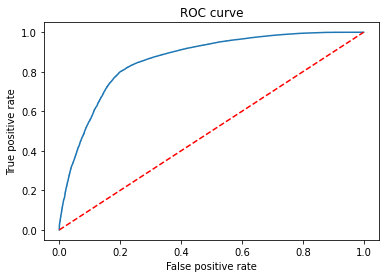

In [16]:
#get the values required to plot a ROC curve
fpr, tpr, thresholds = roc_curve(y_test_prob['Y_test_class_actual'], y_test_prob['y_hat_test_probability']) #false positive rate and true positive rate

# plot the ROC curve
plt.plot(fpr, tpr)

# plot a secondary diagonal line, with dashed line style and black color to represent a no-skill classifier
plt.plot(fpr, fpr, linestyle = '--', color = 'r')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve');

#Metrics for performance of a model on test data

$\text{AUROC score}$

In [17]:
# Calculate the Area Under the Receiver Operating Characteristic Curve (AUROC) on our test set
AUROC = roc_auc_score(y_test_prob['Y_test_class_actual'], y_test_prob['y_hat_test_probability'])
print("AUROC : " , AUROC)

AUROC :  0.8610859787387447


$\text{Gini index value}$

In [18]:
# calculate Gini from AUROC
Gini = AUROC * 2 - 1
print('Gini index : ', Gini)

Gini index :  0.7221719574774894


$\text{Precision Recall curve:}$

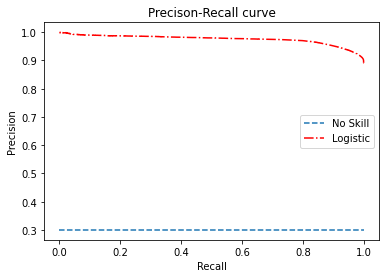

In [20]:
# draw a PR curve
# calculate the no skill line as the proportion of the positive class
no_skill = len(Y_test[Y_test == 1]) / (len(Y_test)+len(Y_train))

#plot the no skill precision-recall curve
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')

#calculate inputs for the PR curve
precision, recall, thresholds = precision_recall_curve(y_test_prob['Y_test_class_actual'], y_test_prob['y_hat_test_probability'])

# plot PR curve
plt.plot(recall, precision, linestyle= '-.', label='Logistic' , color = 'r')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.title('Precison-Recall curve');

$\text{For more information about AUC and PR AUC , read :}$
[AUROC Vs AUCPr](https://https://datascience.stackexchange.com/questions/9003/when-do-i-have-to-use-aucpr-instead-of-auroc-and-vice-versa)

$\text{Value of PR-AUC}$

In [21]:
# calculate PR AUC
auc_pr = auc(recall, precision)
print("value of PR-AUC obtained is : " , auc_pr)

value of PR-AUC obtained is :  0.9756887086928643
